In [62]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pdf2image
import easyocr
import pandas as pd
%matplotlib inline 


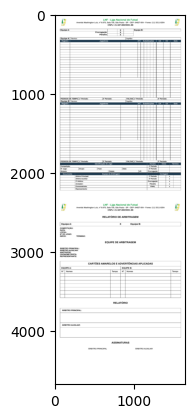

In [63]:
basepdf_path = 'images/input/BASE-LNF.pdf'
images = pdf2image.convert_from_path(basepdf_path)
#merge all pages into one
base = np.vstack(images)
plt.imshow(base)


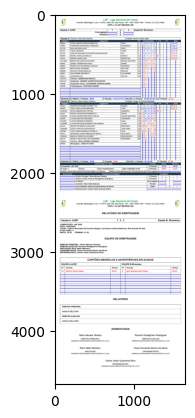

In [64]:
sum_path = 'images/input/Sumula1-LNF.pdf'
images = pdf2image.convert_from_path(sum_path)
#merge all pages into one
sumula = np.vstack(images)
plt.imshow(sumula)

True

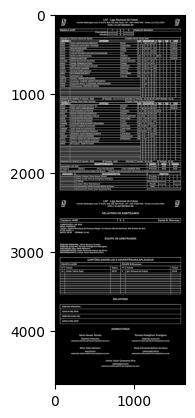

In [65]:
#Test preprocessing the images b4 OCR
def preprocess(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (5,5), 0)
    thresh = cv.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
    return thresh

base_preprocessed = preprocess(base)
sumula_preprocessed = preprocess(sumula)

plt.imshow(base_preprocessed,cmap='gray')
cv.imwrite('images/base_preprocessed.png',base_preprocessed)
plt.imshow(sumula_preprocessed,cmap='gray')
cv.imwrite('images/sumula_preprocessed.png',sumula_preprocessed)


In [66]:
base_gray = cv.cvtColor(base, cv.COLOR_BGR2GRAY)
sumula_gray = cv.cvtColor(sumula, cv.COLOR_BGR2GRAY)

# Usar ORB para detectar e computar as características
orb = cv.ORB_create(50000)

keypoints1, descriptors1 = orb.detectAndCompute(sumula_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(base_gray, None)

# Usar BFMatcher para encontrar correspondências
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Ordenar as correspondências pela distância (qualidade)
matches = sorted(matches, key=lambda x: x.distance)

# Selecionar um número razoável de melhores correspondências para calcular a homografia
good_matches = matches[:500]

# Obter os pontos das correspondências
points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

for i, match in enumerate(good_matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Calcular a homografia usando RANSAC para maior robustez
h, mask = cv.findHomography(points2, points1, cv.RANSAC)

# Aplicar a homografia para alinhar a segunda imagem com a primeira
height, width = sumula_gray.shape
aligned_image2 = cv.warpPerspective(base_gray, h, (width, height))

# Subtrair as imagens alinhadas
subtracted_image = cv.absdiff(sumula_gray, aligned_image2)

# Salvar ou mostrar a imagem subtraída
cv.imwrite('images/test_result(50000).jpg', subtracted_image)


True